# Contributers: Kyle Moses, Irvin Quartey, Marisol Mondragon

## Animal Shelter Intakes and Outcomes Analysis:
## Data set aac_intakes_outcomes.csv from Kaggle
## Question we set out to answer: What factors affect how long it takes for a Dog to get adopted once they are in the shelter?

## 1) What are the most common outcomes across all animals?
## 2) Does Dog age affect outcome type? Do older dogs spend more time in the shelter before getting adopted?
## 3) Do certain Dog breeds spend more time in the shelter before getting adopted?
## 4) Is there a date or time period that more Dogs are adopted more often?

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# DATA CLEANING:

# Read in csv
shelter_df = pd.read_csv('../Resources/aac_intakes_outcomes.csv')

# Giving all animals 1 day in shelter, any time at the shelter rounded to one day
shelter_df["whole_shelter_days"] = np.ceil(shelter_df["time_in_shelter_days"])

# Droped outcome_subtype because of 43,324 null values 
shelter_df = shelter_df.drop(columns=["outcome_subtype"])

# Changes age_upon_intake into shelter from string to a float 
# EX: '10 years' --> 10.0
shelter_df['age_upon_intake'] = shelter_df['age_upon_intake'].map(lambda sub: float(sub.split(' ', 1)[0]))
shelter_df.columns

# Groups shelter data by animal id, some animals get taken to this shelter more than once
# Gets average time spent in shelter per trip for each animal id
# EX: A chihuahua been in and out of the shelter 13 times
grouped_animal_data = shelter_df.groupby(['animal_id_intake'])['whole_shelter_days'].mean()
grouped_animal_data = grouped_animal_data.reset_index()
grouped_animal_data = grouped_animal_data.merge(shelter_df, on=['animal_id_intake', 'whole_shelter_days'])
grouped_animal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66952 entries, 0 to 66951
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   animal_id_intake            66952 non-null  object 
 1   whole_shelter_days          66952 non-null  float64
 2   age_upon_outcome            66952 non-null  object 
 3   animal_id_outcome           66952 non-null  object 
 4   date_of_birth               66952 non-null  object 
 5   outcome_type                66947 non-null  object 
 6   sex_upon_outcome            66951 non-null  object 
 7   age_upon_outcome_(days)     66952 non-null  int64  
 8   age_upon_outcome_(years)    66952 non-null  float64
 9   age_upon_outcome_age_group  66952 non-null  object 
 10  outcome_datetime            66952 non-null  object 
 11  outcome_month               66952 non-null  int64  
 12  outcome_year                66952 non-null  int64  
 13  outcome_monthyear           669

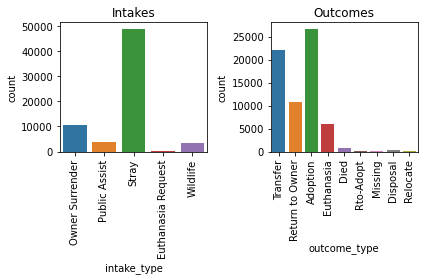

In [3]:
# 1) What are the most common outcomes across all animals?
# Visualizing the data set -- give more insight into what values we have

fig, ax = plt.subplots(1,2)
sns.countplot(grouped_animal_data['intake_type'], ax=ax[0]).set_title("Intakes")
sns.countplot(grouped_animal_data['outcome_type'], ax=ax[1]).set_title("Outcomes")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    fig.tight_layout()

fig.show()

# Insights: Majority of intakes are strays -- majority of outcomes are Adoption

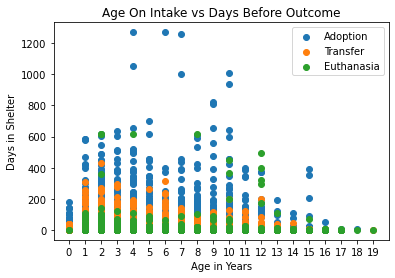

In [4]:
# 2) Does Dog age affect outcome type? Do older dogs spend more time in the shelter before getting adopted?

# Breaks data into Dogs that have been Adopted, Transfered, or Euthanized
dog_outcomes_a = grouped_animal_data.loc[(grouped_animal_data["animal_type"]=="Dog") & 
                                       (grouped_animal_data["outcome_type"] == "Adoption")]
dog_outcomes_t = grouped_animal_data.loc[(grouped_animal_data["animal_type"]=="Dog") & 
                                       (grouped_animal_data["outcome_type"] == "Transfer")]
dog_outcomes_e = grouped_animal_data.loc[(grouped_animal_data["animal_type"]=="Dog") & 
                                       (grouped_animal_data["outcome_type"] == "Euthanasia")]
# Setting axis
x_a=dog_outcomes_a['age_upon_intake']
y_a=dog_outcomes_a['whole_shelter_days']
x_t=dog_outcomes_t['age_upon_intake']
y_t=dog_outcomes_t['whole_shelter_days']
x_e=dog_outcomes_e['age_upon_intake']
y_e=dog_outcomes_e['whole_shelter_days']

# Plotting using Matplotlib
plt.scatter(x_a, y_a, label="Adoption" )
plt.scatter(x_t, y_t, label="Transfer")
plt.scatter(x_e, y_e, label="Euthanasia")
plt.title('Age On Intake vs Days Before Outcome')
plt.xticks(range(0,20))
plt.xlabel('Age in Years')
plt.ylabel('Days in Shelter')
plt.legend()

# Insights: Dogs, if Euthanized, are Euthanized soon after they enter they shelter, same with Transfer due to max occupancy
# NOT GOOD VISUALIZATION BECAUSE DOESNT SHOW HOW MUCH DOGS IN EACH CATEGORY! DID NOT ANSWER OUR QUESTION

In [18]:
# Find outlier dogs that are over 6 years of age and have been at the shelter for over 1000 days 
dog_time_age_outliers=grouped_animal_data.loc[(grouped_animal_data["animal_type"]=="Dog") & (grouped_animal_data["age_upon_intake"] < 6) & (grouped_animal_data["whole_shelter_days"] > 1000), ["breed", "age_upon_intake", "outcome_type"]]
dog_time_age_outliers.head()

,breed,age_upon_intake,outcome_type
14888,Pit Bull Mix,4.0,Adoption
21602,Pit Bull Mix,4.0,Return to Owner
24679,American Bulldog Mix,4.0,Adoption


<AxesSubplot:xlabel='age_upon_intake', ylabel='whole_shelter_days'>

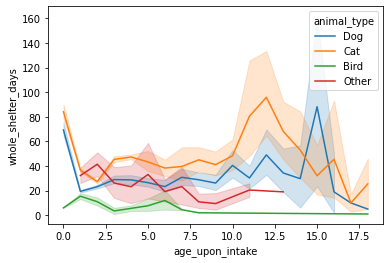

In [6]:
# How does dog age upon intake and how long they spend in the shelter, compare to other animal types?

# Finding animals that were adopted 
adopted_animals = grouped_animal_data.loc[grouped_animal_data["outcome_type"] == "Adoption"]
sns.lineplot(data=adopted_animals,x='age_upon_intake',y='whole_shelter_days',hue="animal_type")

# Insights: Time spent in shelter is fairly even for dogs, but higher on average for cats especially as they get older
# People don't want to adopt older pets, people don't want super young cats or dogs

In [7]:
# Gets list of dogs that were adopted as their outcome_type
adopted_dogs = grouped_animal_data.loc[(grouped_animal_data["animal_type"]=="Dog") & (grouped_animal_data["outcome_type"]=="Adoption")]

# Gets breed value counts (1235 unique breeds)
value_counts = adopted_dogs["breed"].value_counts()
value_counts = value_counts.reset_index()
value_counts = value_counts.rename(columns={'index': 'breed', 'breed': 'count'})

# Displaying the top most adopted breeds
value_counts.head()

,breed,count
0,Chihuahua Shorthair Mix,1870
1,Labrador Retriever Mix,1799
2,Pit Bull Mix,1464
3,German Shepherd Mix,653
4,Australian Cattle Dog Mix,447


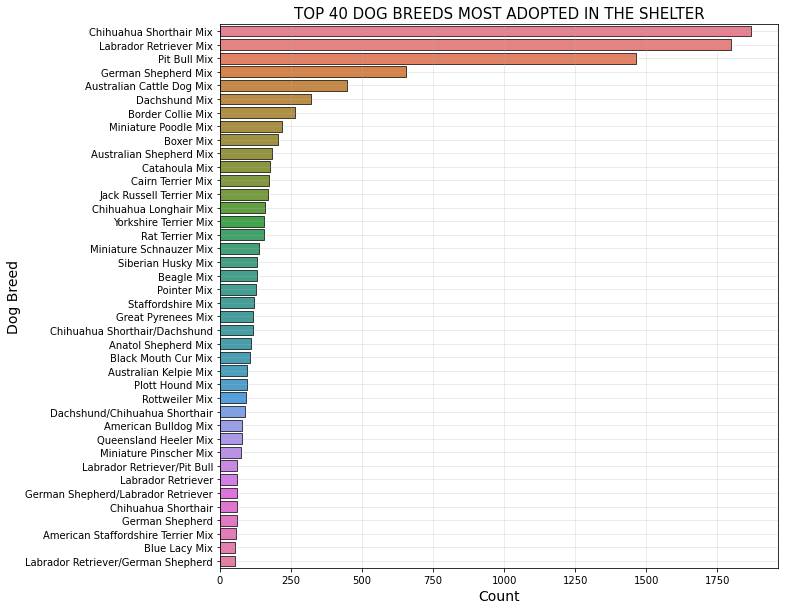

In [8]:
# Finding breeds that were adopted the most 
breed = adopted_dogs.groupby(['breed'])[['count']].sum().reset_index().sort_values(by='count', ascending=False)
breed_40 = breed.head(40)

# Use seaborn to plot Bar Chart
fig = plt.figure(figsize=(10,10))
sns.barplot('count','breed',
                 data=breed_40, palette='husl', linewidth=0.7, edgecolor='k')
plt.ylabel('Dog Breed', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.title('TOP 40 DOG BREEDS MOST ADOPTED IN THE SHELTER', fontsize=15)
plt.grid(True,alpha= .3)

# Insights: Seems to be more Chihuahua's Retrievers and Pit Bulls

In [9]:
# 3) Do certain Dog breeds spend more time in the shelter before getting adopted?

# Grouping by breed and getting an AVERAGE of how much time each breed spends in the shelter 
avg_days_by_dog_breed = adopted_dogs.groupby(['breed'])['whole_shelter_days'].mean()
avg_days_by_dog_breed = avg_days_by_dog_breed.reset_index()

# Grouping by breed and getting AVERAGE age on intake into shelter
avg_age_by_dog_breed = adopted_dogs.groupby(['breed'])['age_upon_intake'].mean()
avg_age_by_dog_breed = avg_age_by_dog_breed.reset_index()

# Merging average tables and breed value counts together on breed 
avg_days_by_dog_breed = avg_days_by_dog_breed.merge(value_counts, on=['breed'])
avg_days_age_breed = avg_days_by_dog_breed.merge(avg_age_by_dog_breed, on=['breed'])

# Only looking for counts of breeds above 120 to ensure better averages (law of large numbers)
avg_days_age_breed = avg_days_age_breed.rename(columns={'whole_shelter_days': 'avg_time_in_shelter', 'age_upon_intake': 'avg_age_upon_intake'})
avg_days_age_breed = avg_days_age_breed.loc[avg_days_by_dog_breed['count'] >= 120]
avg_days_age_breed.head()

,breed,avg_time_in_shelter,count,avg_age_upon_intake
62,Australian Cattle Dog Mix,26.257271,447,3.382550
116,Australian Shepherd Mix,15.879781,183,3.060109
161,Beagle Mix,16.638462,130,3.338462
238,Border Collie Mix,17.284091,264,3.303030
285,Boxer Mix,33.068966,203,3.290640


In [10]:
# Trying to find correltation between avg age and how long on avg a dog spends in the shelter before adoption
# No strong correltation, slight negative correltation of -0.299853
avg_days_age_breed.corr()

,avg_time_in_shelter,count,avg_age_upon_intake
avg_time_in_shelter,1.000000,0.333267,-0.299853
count,0.333267,1.000000,-0.280880
avg_age_upon_intake,-0.299853,-0.280880,1.000000


Text(0, 0.5, 'Average Days Spent in Shelter')

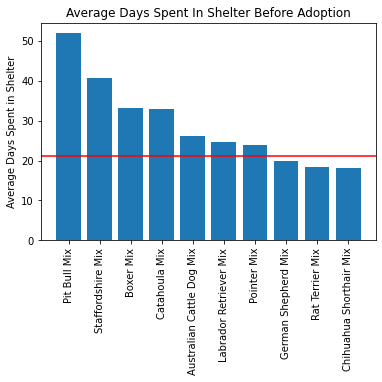

In [11]:
# Sort breeds by average time spent in shelter before adoption in Descending
avg_days_age_breed = avg_days_age_breed.sort_values(by=['avg_time_in_shelter'], ascending=False)

# Gets top ten breeds with highest average time in shelter
top_ten_most_time = avg_days_age_breed.head(10)
plt.bar(x=top_ten_most_time['breed'], height=top_ten_most_time['avg_time_in_shelter'])

# Shows average days spent in shelter across all breeds with average line on graph (avg = 21)
plt.axhline(y=avg_days_age_breed['avg_time_in_shelter'].mean(), color = 'r', linestyle = '-')

plt.xticks(rotation='vertical')
plt.title('Average Days Spent In Shelter Before Adoption')
plt.ylabel('Average Days Spent in Shelter')

# Insights: Pit Bull, Staffordshire and Boxer all above the average for days spent in shelter before adoption
# These top 3 dogs look failry similar, stereotypes about Pit Bull breeds may bleed into other dog breeds

<p float="left">
  <img src='../Resources/pitbull.jpg' width="250" height="350" />
  <img src='../Resources/Staffordshire.jpeg' width="250" height="350" />
  <img src='../Resources/boxer.jpeg' width="250" height="350" />
</p>

In [12]:
# Dogs that spend least amount of time in shelter on average before adoption
avg_days_age_breed = avg_days_age_breed.sort_values(by=['avg_time_in_shelter'], ascending=True)
avg_days_age_breed.head()
# Insights: Top  are small dogs

,breed,avg_time_in_shelter,count,avg_age_upon_intake
882,Miniature Schnauzer Mix,8.933824,136,3.588235
1227,Yorkshire Terrier Mix,10.128205,156,3.410256
864,Miniature Poodle Mix,11.654545,220,3.668182
517,Dachshund Mix,11.981308,321,3.610592
393,Chihuahua Longhair Mix,12.414013,157,3.541401


<p float="left">
  <img src='../Resources/schnauzer.jpeg' width="200" height="350" />
  <img src='../Resources/rat terrier.jpeg' width="200" height="350" />
  <img src='../Resources/miniature poodle.jpeg' width="200" height="350" />
  <img src='../Resources/yorkshire mix.jpeg' width="200" height="350" />
</p>

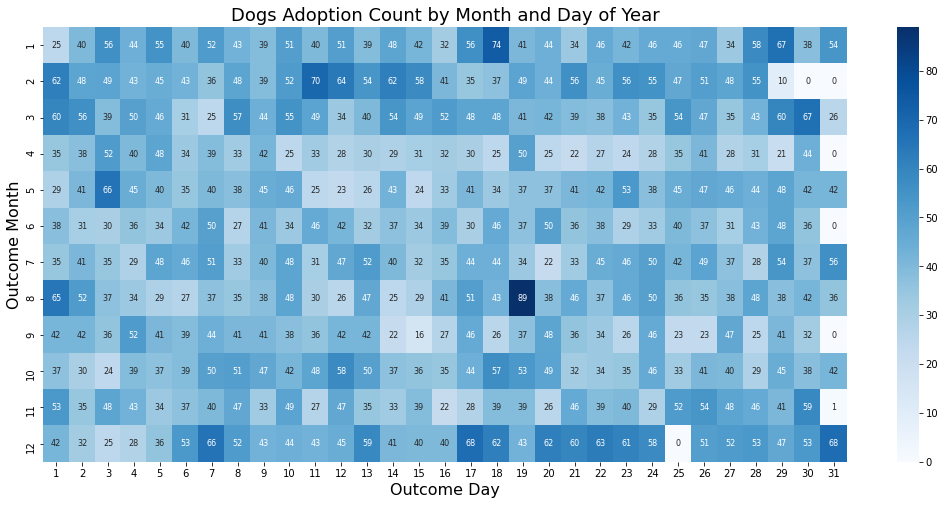

In [13]:
# 4) Is there a date or time period that more Dogs are adopted more often?

adopted_dogs['outcome_day'] = pd.DatetimeIndex(adopted_dogs['outcome_datetime']).day
outcome_md = adopted_dogs.groupby(['outcome_day','outcome_month'])[['count']].sum()
outcome_md = outcome_md.reset_index(level=[0,1])
pivoted_table = outcome_md.pivot(index='outcome_month', columns='outcome_day', values='count')
pivoted_table.fillna(0, inplace=True)
plt.figure(figsize=(18, 8))
sns.heatmap(pivoted_table, cmap='Blues', annot=True, fmt='g', annot_kws={'size': 8})
plt.title('Dogs Adoption Count by Month and Day of Year', fontsize=18);
plt.xlabel('Outcome Day', fontsize=16)
plt.ylabel('Outcome Month', fontsize=16);

# Insights: August 19th the adoption fee was waived, more dog adoptions occur when they are free or discounted
# Otherwise no strong correlation for days